In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import os

In [5]:
# Note: Due to that the csv file has an extra column (first), all coulumns are moved 1 index up and since 
# python uses index 0 for the first entry, all entries here are column -2 in the manual section 7.3
    

# target directory, this will attept to read all files (if too large, memory will be an issue)
# a solution could be to store monthly netcdfs, anotherone could be to use zarr files
dir = '/home/erlend/offline_data/Thies_dec2021/' 

# get list of filenames
files = sorted(os.listdir(dir)) 

times = []
one_m_synop = []
precip_spectrum = []
total_precip = []
liquid_precip = []
solid_precip = []
for file_i in range(len(files)):
    # read file
    df = pd.read_csv(dir + files[file_i], sep=';', header=None)

    # get date from filename
    year, month, day = files[file_i].split('T')[0].split('-')
    
    times_ = []
    for i in range(df[0].size): # number of observations
        # read and format first column (time)
        hour, minute, second = df[0][i].split('.')[0][1:].split(':') 
        times.append(pd.to_datetime(year + month + day + hour + minute + second, format='%Y%m%d%H%M%S'))
    
        # create numpy array and reshape to same format as data array
    times.append(np.array(times_).reshape(-1, 1))
    
    # read precipitation classification
    one_m_synop.append(df.iloc[:, 9].values.reshape(-1, 1)) # col 11

    # read precipitation spectrum
    precip_spectrum.append(df.iloc[:, 79:519].values) # col 81 - 521 (exclude 521)

    # read precipitation ammounts
    total_precip.append(df.iloc[:, 12].values.reshape(-1, 1)) # col 14
    liquid_precip.append(df.iloc[:, 13].values.reshape(-1, 1)) # col 15
    solid_precip.append(df.iloc[:, 14].values.reshape(-1, 1)) # col 16

# concatenate arrays, time along vertical dimension
times = np.vstack(times)
one_m_synop = np.vstack(one_m_synop)
precip_spectrum = np.vstack(precip_spectrum) 
total_precip = np.vstack(total_precip) 
liquid_precip = np.vstack(liquid_precip) 
solid_precip = np.vstack(solid_precip) 

In [7]:
ds = xr.Dataset(
    data_vars= dict(
        one_m_synop=(['time'], one_m_synop.ravel()),
        total_precip=(['time'], total_precip.ravel()),
        liquid_precip=(['time'], liquid_precip.ravel()),
        solid_precip=(['time'], solid_precip.ravel()),
        
        precip_spectrum = (['time', 'diameter_lower', 'particle_speed_lower'], precip_spectrum.reshape(precip_spectrum.shape[0], 22, 20))
    ),
    coords=dict(
        time = ('time', times.ravel()),
        diameter_lower = ('diameter_lower', [0.125, 0.25, 0.375, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2, 2.5, 3, 3.5, 4, 4.5, 5, 5.5, 6, 6.5, 7, 7.5, 8]),
        particle_speed_lower = ('particle_speed_lower', [0, 0.2, 0.4, 0.6, 0.8, 1, 1.4, 1.8, 2.2, 2.6, 3, 3.4, 4.2, 5, 5.8, 6.6, 7.4, 8.2, 9, 10]),
        
    ),
)

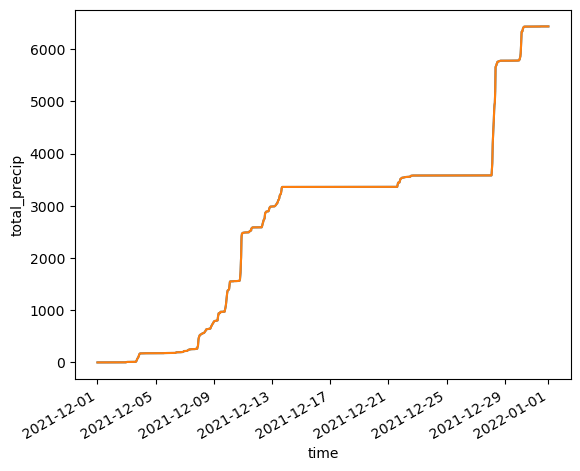

In [9]:
# test: equal
(ds.liquid_precip + ds.solid_precip).cumsum().plot()
ds.total_precip.cumsum().plot()


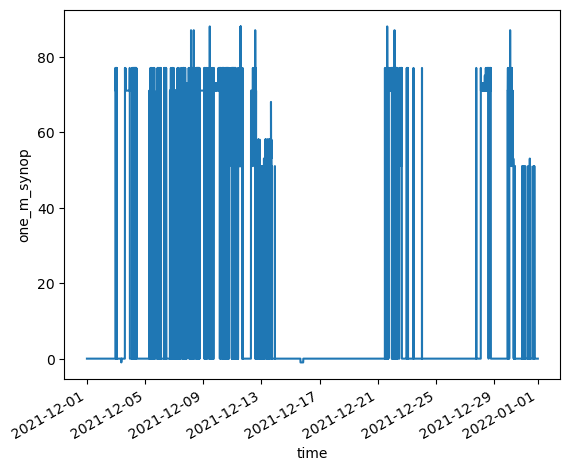

In [4]:
ds.one_m_synop.plot()

/home/erlend/anaconda3/lib/python3.9/site-packages/xarray/core/computation.py:760: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)


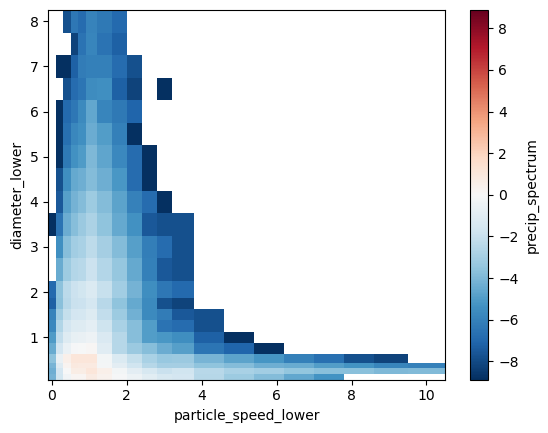

In [13]:
# rainy period:
np.log(ds.sel(time = slice('2021-12-05', '2021-12-09')).precip_spectrum.mean(dim = 'time')).plot()

/home/erlend/anaconda3/lib/python3.9/site-packages/xarray/core/computation.py:760: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)


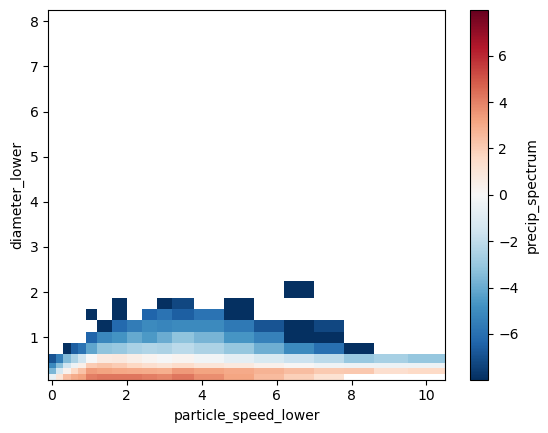

In [12]:
# snowy period:
np.log(ds.sel(time = slice('2021-12-13', '2021-12-14')).precip_spectrum.mean(dim = 'time')).plot()